In [40]:
from sklearn import datasets
import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt
from collections import deque
from sklearn.neighbors import KDTree
from sklearn.preprocessing import OrdinalEncoder
from sklearn.cluster import DBSCAN, OPTICS
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.preprocessing import StandardScaler

from dbscanpp import DBSCANPP


In [8]:
dataset_name = 'C'


In [9]:
def read_data(dataset_name):
    enc = OrdinalEncoder()

    if dataset_name == 'A':
        # (A) iris
        iris = datasets.load_iris()
        X = iris['data']
        y = iris['target']

    elif dataset_name == 'B':
        # (B) wine
        wine = datasets.load_wine()
        X = wine['data']
        y = wine['target']

    elif dataset_name == 'C':
        # (C) spam
        X = pd.read_csv('../data/spambase.csv', header=None)
        X.rename(columns={57: 'is_spam'}, inplace=True)
        
        y = X['is_spam'].to_numpy()
        X = X.iloc[:, X.columns != 'is_spam'].to_numpy()

    elif dataset_name == 'D':
        # (D) images
        X, y = None, None

    elif dataset_name == 'E':
        # (E) MNIST
        # NOT WORKING!
        X = pd.read_csv('../data/mnist_train.csv')

        y = X['label'].to_numpy()
        X = X.iloc[:, X.columns != 'label'].to_numpy()

        y = enc.fit_transform(y[:, None]).flatten()
        
        X, y = None, None

    elif dataset_name == 'F':
        # (F) Libras
        X = pd.read_csv('../data/movement_libras.csv')

        y = X['class'].to_numpy()
        X = X.iloc[:, X.columns != 'class'].to_numpy()

    elif dataset_name == 'G':
        # (G) mobile
        X, y = None, None

    elif dataset_name == 'H':
        # (H) zoo
        X = pd.read_csv('../data/zoo.csv')

        X.drop(['animal_name'], axis=1, inplace=True)
        y = X['type'].to_numpy()
        X = X.iloc[:, X.columns != 'type'].to_numpy()

    elif dataset_name == 'I':
        # (I) seeds
        X = pd.read_csv('../data/seeds_dataset.csv', sep='\t+', engine='python')

        y = X['class'].to_numpy()
        X = X.iloc[:, X.columns != 'class'].to_numpy()

    elif dataset_name == 'J':
        # (J) letters
        X = pd.read_csv('../data/letter-recognition.csv')

        y = X['lettr'].to_numpy()
        X = X.iloc[:, X.columns != 'lettr'].to_numpy()

        y = enc.fit_transform(y[:, None]).flatten()

    elif dataset_name == 'K':
        # (K) phonemes
        X = pd.read_csv('../data/phoneme.csv')

        y = X['g'].to_numpy()
        X = X[X.columns.difference(['g', 'speaker', 'row.names'])].to_numpy()

        y = enc.fit_transform(y[:, None]).flatten()

    return X, y

In [10]:
0.2*np.power(101, 16 / (16 + 4))

8.025777114607378

In [11]:
for dataset_name in ['A', 'B', 'C', 'F', 'H', 'I', 'J', 'K']:
    X, y = read_data(dataset_name)
    print(f'Dataset ({dataset_name})')
    print(X.shape)
    print(f'N. clusters: {len(np.unique(y))}')
    print()

Dataset (A)
(150, 4)
N. clusters: 3

Dataset (B)
(178, 13)
N. clusters: 3

Dataset (C)
(4601, 57)
N. clusters: 2

Dataset (F)
(360, 90)
N. clusters: 15

Dataset (H)
(101, 16)
N. clusters: 7

Dataset (I)
(210, 7)
N. clusters: 3

Dataset (J)
(20000, 16)
N. clusters: 26

Dataset (K)
(4509, 256)
N. clusters: 5



In [12]:
def compute_metrics(labels_true, labels_pred):
    results = {'n_outliers': 0,
               'n_clusters': 0,
               'adj_rand': 0,
               'adj_mutual_info': 0,
               }

    if labels_true is None or labels_pred is None:
        return results

    results['n_clusters'] = len(np.unique(labels_pred) -
                                (1 if -1 in np.unique(labels_pred) else 0))
    results['n_outliers'] = (labels_pred == -1).sum()
    results['adj_rand'] = adjusted_rand_score(labels_true, labels_pred)
    results['adj_mutual_info'] = adjusted_mutual_info_score(labels_true, labels_pred)

    return results


In [13]:
epsilon_range = {
    'A': (0.1, 7.5), 
    'B': (1.6, 8.5), 
    'C': (0.1, 16.5), 
    'F': (0.6, 14.5), 
    'H': (0.8, 9), 
    'I': (0.3, 6.5), 
    'J': (0.1, 6), 
    'K': (6, 15) 
}

Training dataset A
	Training epsilon 0.1
	Training epsilon 0.9222222222222223
	Training epsilon 1.7444444444444447
	Training epsilon 2.566666666666667
	Training epsilon 3.3888888888888893
	Training epsilon 4.211111111111111
	Training epsilon 5.033333333333333
	Training epsilon 5.855555555555556
	Training epsilon 6.677777777777778
	Training epsilon 7.5
Training dataset B
	Training epsilon 1.6
	Training epsilon 2.3666666666666667
	Training epsilon 3.1333333333333337
	Training epsilon 3.9000000000000004
	Training epsilon 4.666666666666667
	Training epsilon 5.433333333333334
	Training epsilon 6.200000000000001
	Training epsilon 6.966666666666667
	Training epsilon 7.733333333333334
	Training epsilon 8.5
Training dataset C
	Training epsilon 0.1
	Training epsilon 1.922222222222222
	Training epsilon 3.744444444444444
	Training epsilon 5.5666666666666655
	Training epsilon 7.3888888888888875
	Training epsilon 9.21111111111111
	Training epsilon 11.033333333333331
	Training epsilon 12.855555555555

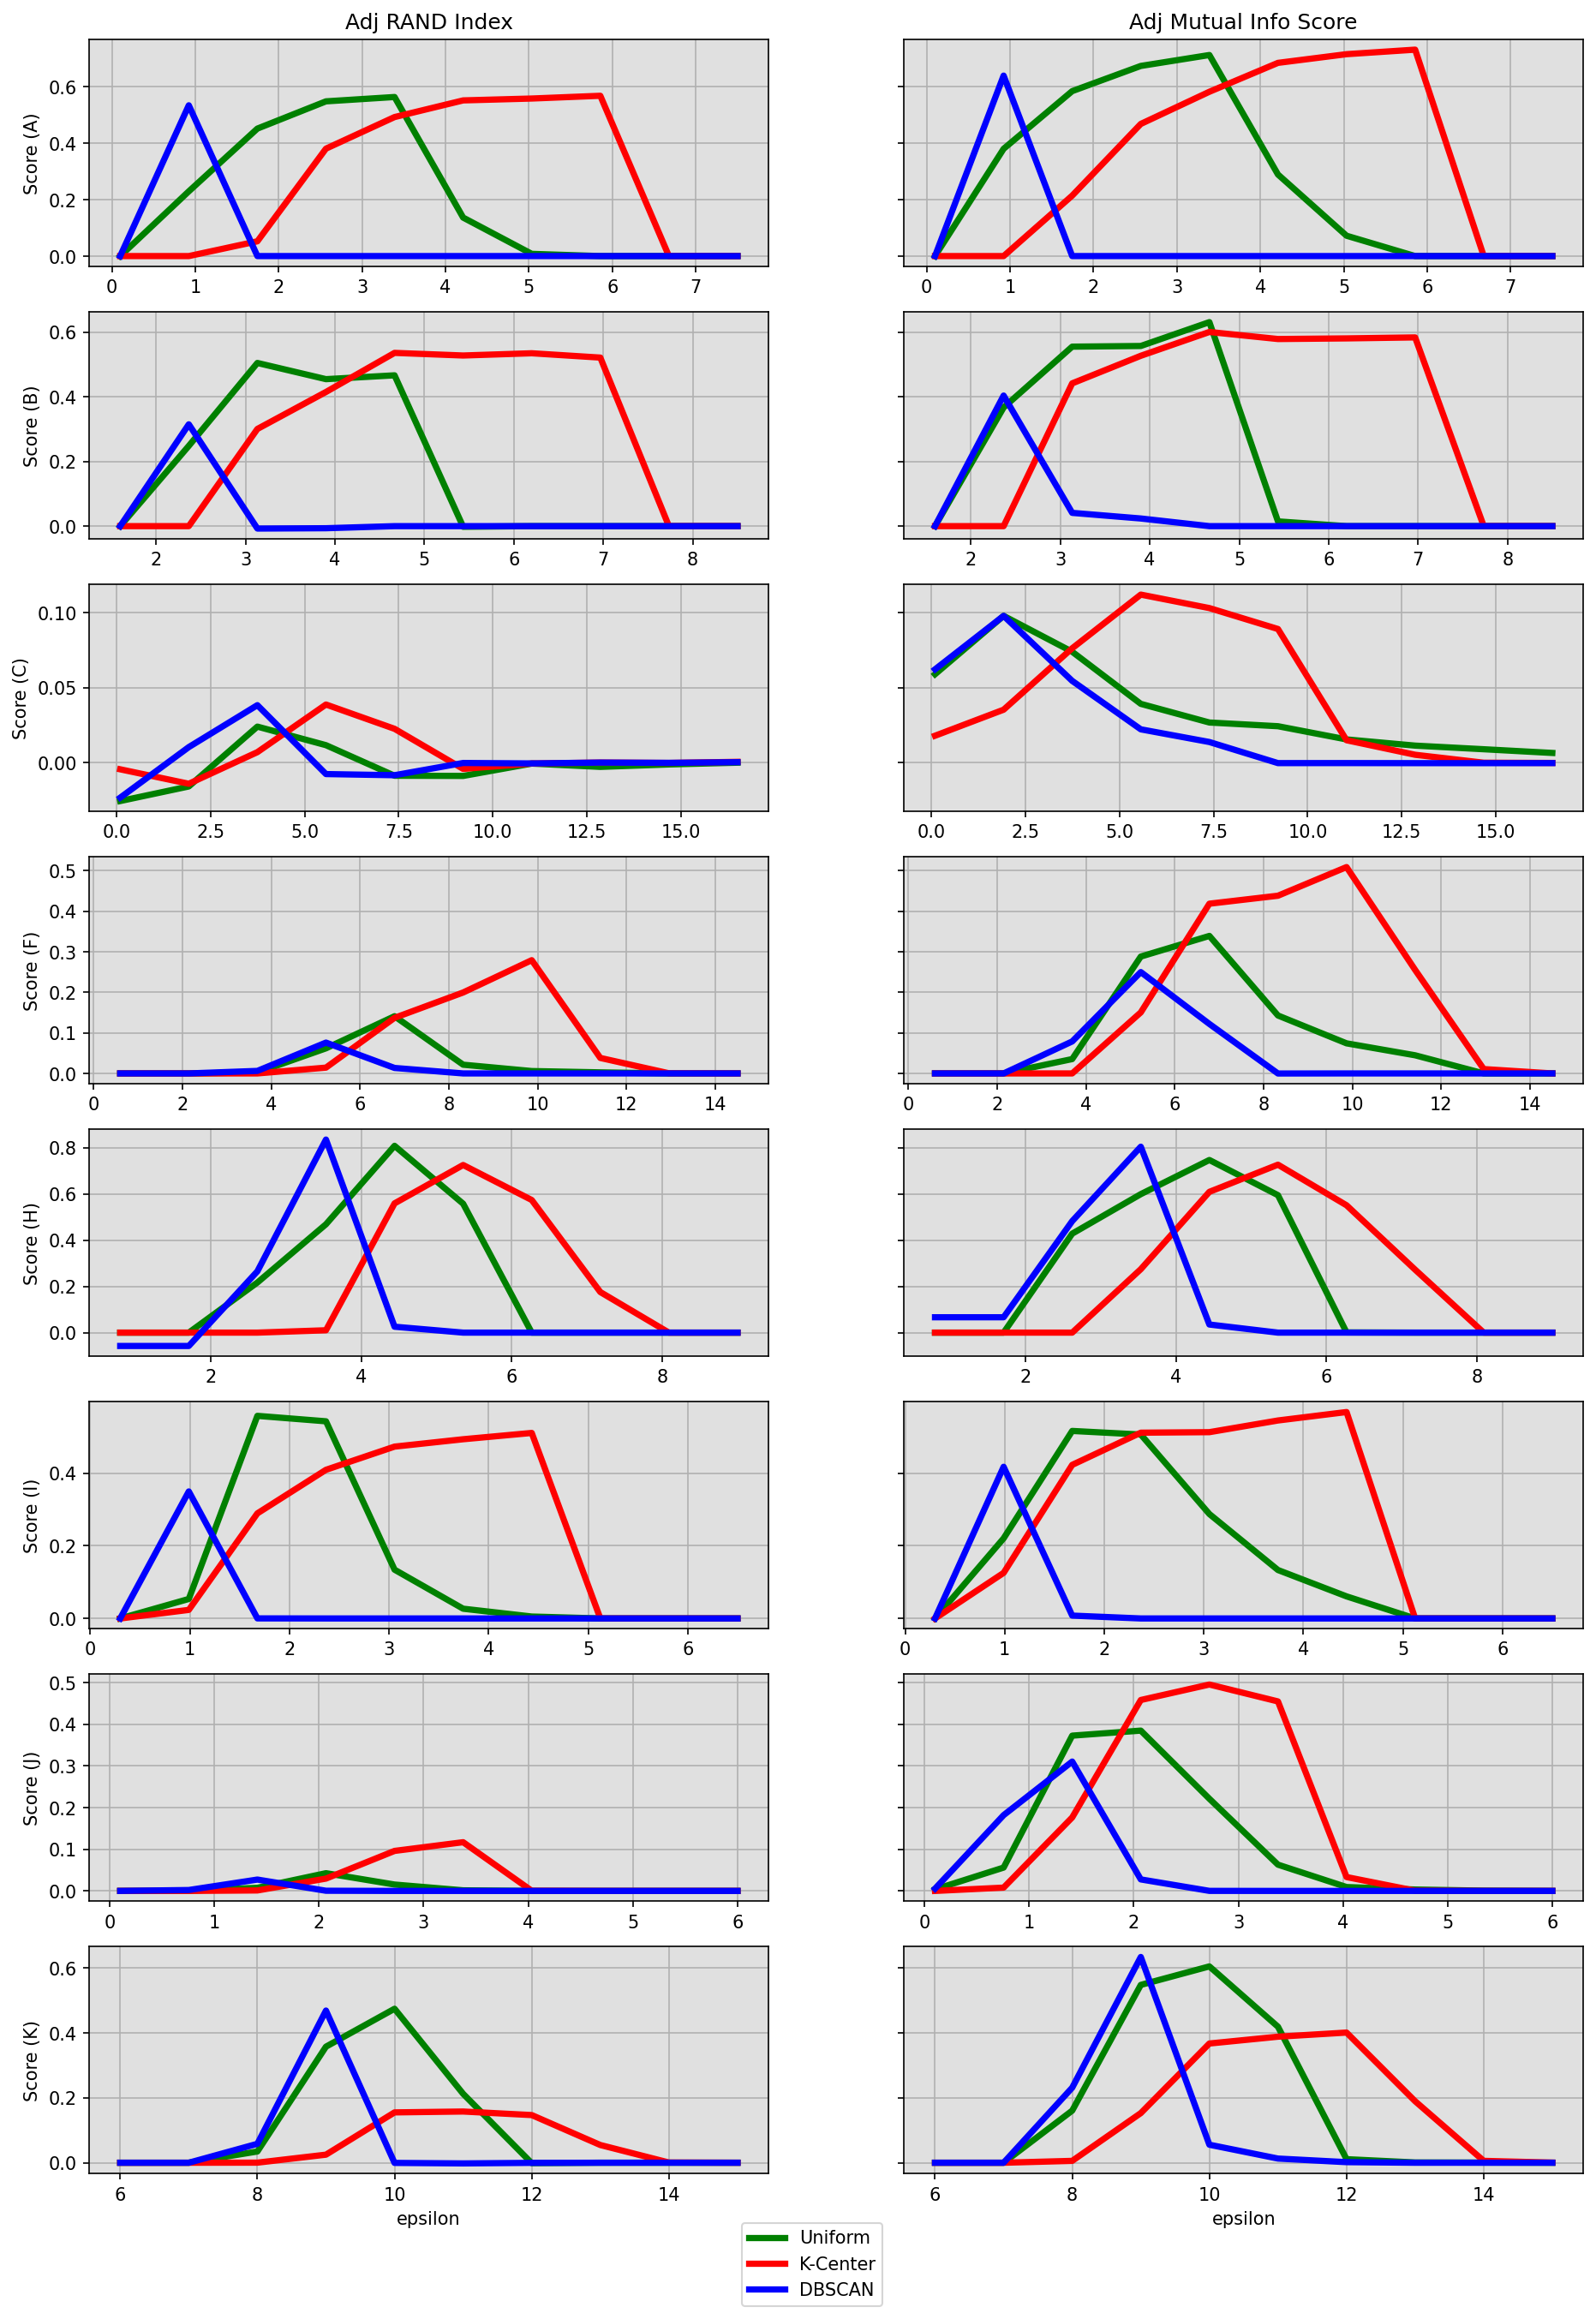

In [40]:
all_datasets = ['A', 'B', 'C', 'F', 'H', 'I', 'J', 'K']

fig, axs = plt.subplots(len(all_datasets), 2,
                        sharey='row', figsize=(15, 22), dpi=150)

for row_, dataset_name in enumerate(all_datasets):
    print(f'Training dataset {dataset_name}')

    X, y = read_data(dataset_name)
    X = StandardScaler().fit_transform(X)

    axs[row_, 0].set(ylabel='Score (' + dataset_name + ')')

    minPts = 10

    epsilons = np.linspace(epsilon_range[dataset_name][0],
                           epsilon_range[dataset_name][1],
                           10)

    scores = {
        'adj_rand': {
            'uniform': [],
            'k-center': [],
            'dbscan': []
        },
        'adj_mutual_info': {
            'uniform': [],
            'k-center': [],
            'dbscan': []
        }
    }
    for epsilon in epsilons:
        print(f'\tTraining epsilon {epsilon}')

        scores['adj_rand']['k-center'].append(-np.inf)
        scores['adj_mutual_info']['k-center'].append(-np.inf)
        
        scores['adj_rand']['uniform'].append(-np.inf)
        scores['adj_mutual_info']['uniform'].append(-np.inf)
        
        for p in [0.1, 0.2, 0.3]:
            m = int(p*np.power(len(X), X.shape[1] / (X.shape[1] + 4)))
            model = DBSCANPP(m, epsilon, minPts)
            
            # K-Center
            labels_pred = model.fit_predict(X, sampling='k-center')
            metrics = compute_metrics(y, labels_pred)
            
            if metrics['adj_rand'] > scores['adj_rand']['k-center'][-1]:
                scores['adj_rand']['k-center'][-1] = metrics['adj_rand']
            if metrics['adj_mutual_info'] > scores['adj_mutual_info']['k-center'][-1]:
                scores['adj_mutual_info']['k-center'][-1] = metrics['adj_mutual_info']

            # Uniform
            labels_pred = model.fit_predict(X, sampling='uniform')
            metrics = compute_metrics(y, labels_pred)
            
            if metrics['adj_rand'] > scores['adj_rand']['uniform'][-1]:
                scores['adj_rand']['uniform'][-1] = metrics['adj_rand']
            if metrics['adj_mutual_info'] > scores['adj_mutual_info']['uniform'][-1]:
                scores['adj_mutual_info']['uniform'][-1] = metrics['adj_mutual_info']
            
        # DBSCAN    
        labels_pred = DBSCAN(eps=epsilon, min_samples=minPts).fit_predict(X)

        metrics = compute_metrics(y, labels_pred)
        scores['adj_rand']['dbscan'].append(metrics['adj_rand'])
        scores['adj_mutual_info']['dbscan'].append(metrics['adj_mutual_info'])

    if row_ == len(all_datasets) - 1:
        axs[row_, 0].plot(epsilons, scores['adj_rand']['uniform'],
                          label='Uniform', color='green', linewidth=3.5)
        axs[row_, 0].plot(epsilons, scores['adj_rand']['k-center'],
                          label='K-Center', color='red', linewidth=3.5)
        axs[row_, 0].plot(epsilons, scores['adj_rand']['dbscan'],
                          label='DBSCAN', color='blue', linewidth=3.5)
    else:
        axs[row_, 0].plot(epsilons, scores['adj_rand']['uniform'],
                          color='green', linewidth=3.5)
        axs[row_, 0].plot(epsilons, scores['adj_rand']['k-center'],
                          color='red', linewidth=3.5)
        axs[row_, 0].plot(epsilons, scores['adj_rand']['dbscan'],
                          color='blue', linewidth=3.5)

    axs[row_, 1].plot(epsilons, scores['adj_mutual_info']['uniform'],
                      color='green', linewidth=3.5)
    axs[row_, 1].plot(epsilons, scores['adj_mutual_info']['k-center'],
                      color='red', linewidth=3.5)
    axs[row_, 1].plot(epsilons, scores['adj_mutual_info']['dbscan'],
                      color='blue', linewidth=3.5)

for ax in fig.axes:
    ax.set_facecolor('#E0E0E0')
    ax.grid(True)

axs[0, 0].set_title('Adj RAND Index')
axs[0, 1].set_title('Adj Mutual Info Score')
axs[len(all_datasets) - 1, 0].set(xlabel='epsilon')
axs[len(all_datasets) - 1, 1].set(xlabel='epsilon')

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, bbox_to_anchor=(0.5, 0.075), loc='lower center')

plt.savefig('score_epsilon.png', transparent=False)
plt.show()


In [8]:
chosen_epsilon = {
    'A': 1, 
    'B': 2.6, 
    'C': 2.7, 
    'F': 6, 
    'H': 3, 
    'I': 0.9, 
    'J': 1.5, 
    'K': 9
}

Training dataset A
	Training m/n = 0.1
	Training m/n = 0.25
	Training m/n = 0.4
	Training m/n = 0.5499999999999999
	Training m/n = 0.7
	Training m/n = 0.85
	Training m/n = 1.0
Training dataset B
	Training m/n = 0.1
	Training m/n = 0.25
	Training m/n = 0.4
	Training m/n = 0.5499999999999999
	Training m/n = 0.7
	Training m/n = 0.85
	Training m/n = 1.0
Training dataset C
	Training m/n = 0.1
	Training m/n = 0.25
	Training m/n = 0.4
	Training m/n = 0.5499999999999999
	Training m/n = 0.7
	Training m/n = 0.85
	Training m/n = 1.0
Training dataset F
	Training m/n = 0.1
	Training m/n = 0.25
	Training m/n = 0.4
	Training m/n = 0.5499999999999999
	Training m/n = 0.7
	Training m/n = 0.85
	Training m/n = 1.0
Training dataset H
	Training m/n = 0.1
	Training m/n = 0.25
	Training m/n = 0.4
	Training m/n = 0.5499999999999999
	Training m/n = 0.7
	Training m/n = 0.85
	Training m/n = 1.0
Training dataset I
	Training m/n = 0.1
	Training m/n = 0.25
	Training m/n = 0.4
	Training m/n = 0.5499999999999999
	Trai

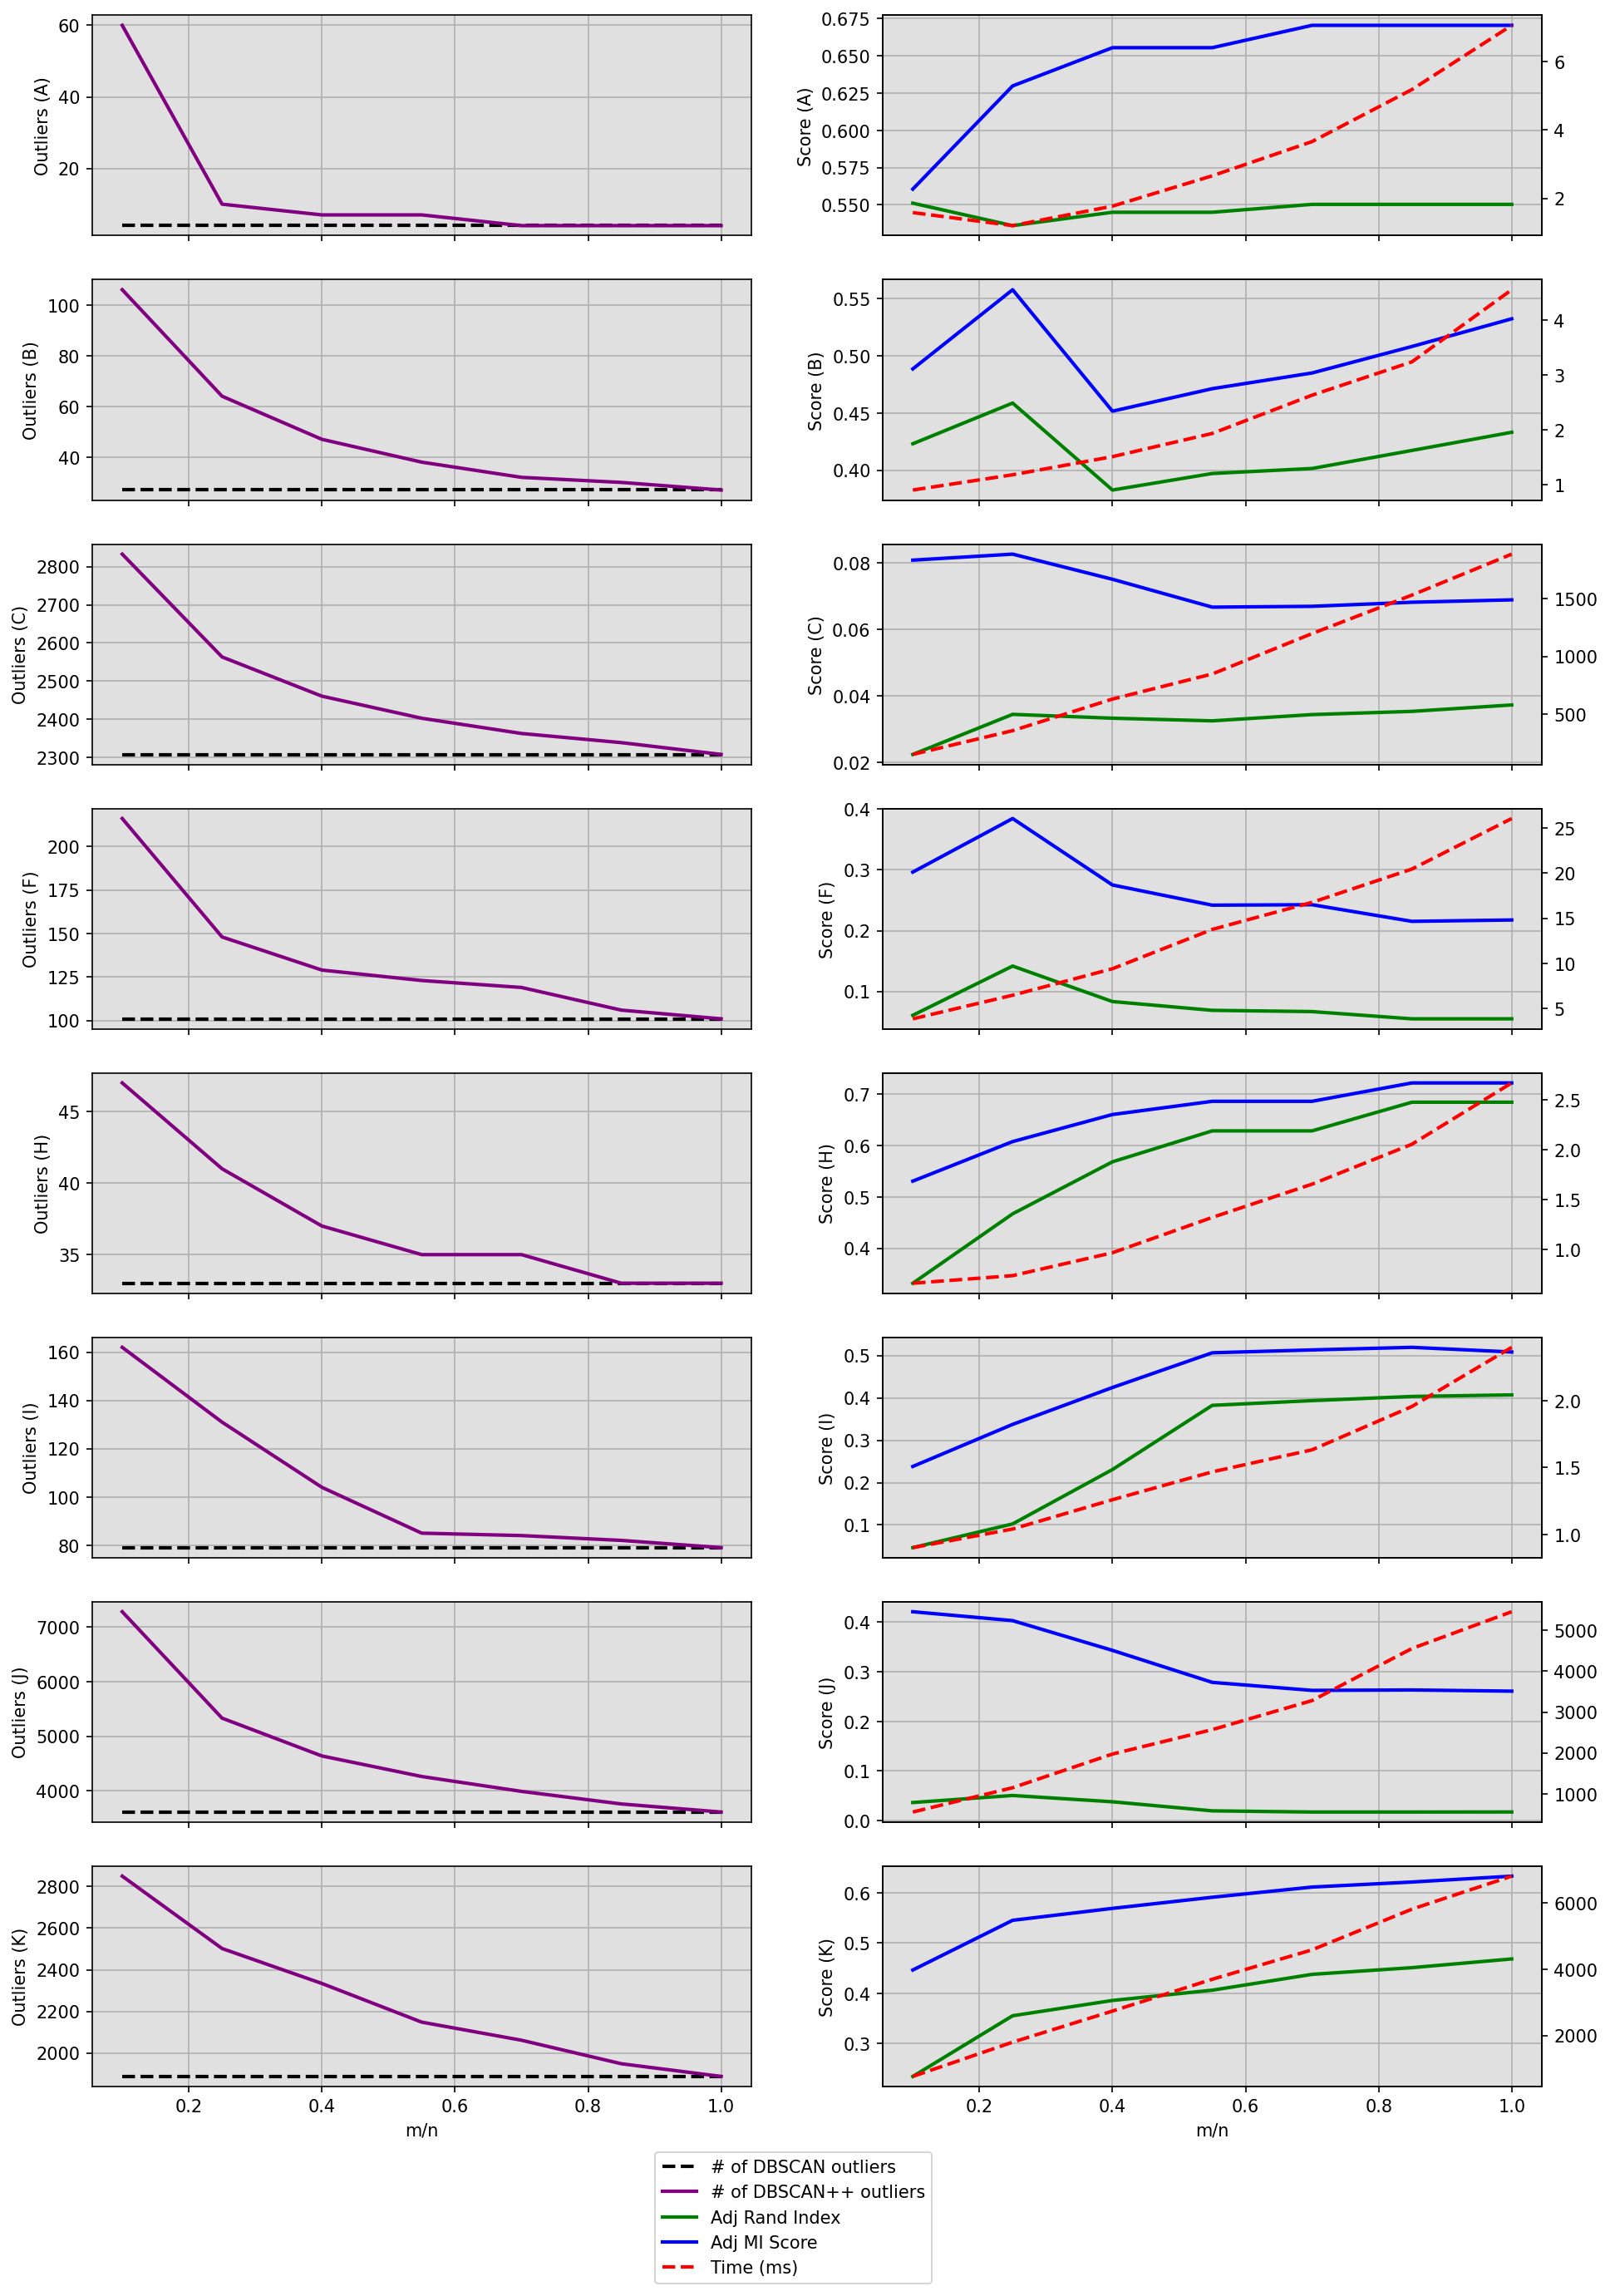

In [9]:
all_datasets = ['A', 'B', 'C', 'F', 'H', 'I', 'J', 'K']
# all_datasets = ['A', 'B', 'C']

fig, axs = plt.subplots(len(all_datasets), 2,
                        sharex=True, figsize=(15, 22), dpi=150)

for row_, dataset_name in enumerate(all_datasets):
    print(f'Training dataset {dataset_name}')

    X, y = read_data(dataset_name)
    X = StandardScaler().fit_transform(X)

    axs[row_, 0].set(ylabel='Outliers (' + dataset_name + ')')
    axs[row_, 1].set(ylabel='Score (' + dataset_name + ')')

    minPts = 10
    epsilon = chosen_epsilon[dataset_name]

    scores = {
        'n_outliers': [],
        'time': [],
        'adj_rand': [],
        'adj_mutual_info': [],
    }

    all_fractions = np.linspace(0.1, 1, 7)
    for fraction in all_fractions:
        print(f'\tTraining m/n = {fraction}')
        m = int(fraction*len(X))

        t0 = time()
        labels_pred = DBSCANPP(m, epsilon, minPts).fit_predict(
            X, sampling='uniform')
        t1 = time()
        metrics = compute_metrics(y, labels_pred)

        scores['n_outliers'].append(metrics['n_outliers'])
        scores['time'].append((t1 - t0)*1000)
        scores['adj_rand'].append(metrics['adj_rand'])
        scores['adj_mutual_info'].append(metrics['adj_mutual_info'])

    # DBSCAN
    labels_pred = DBSCAN(eps=epsilon, min_samples=minPts).fit_predict(X)
    metrics = compute_metrics(y, labels_pred)
    n_outliers_dbscan = metrics['n_outliers']

    if row_ == len(all_datasets) - 1:
        axs[row_, 0].hlines(y=n_outliers_dbscan, xmin=all_fractions[0], xmax=all_fractions[-1], colors='black',
                            linestyles='--', lw=2, label='# of DBSCAN outliers')
        axs[row_, 0].plot(all_fractions, scores['n_outliers'],
                          color='purple', linewidth=2, label='# of DBSCAN++ outliers')

        axs[row_, 1].plot(all_fractions, scores['adj_rand'],
                          color='green', linewidth=2, label='Adj Rand Index')
        axs[row_, 1].plot(all_fractions, scores['adj_mutual_info'],
                          color='blue', linewidth=2, label='Adj MI Score')

        ax_ = axs[row_, 1].twinx()
        ax_.plot(all_fractions, scores['time'], linestyle='--',
                 color='red', linewidth=2, label='Time (ms)')
    else:
        axs[row_, 0].hlines(y=n_outliers_dbscan, xmin=all_fractions[0], xmax=all_fractions[-1],
                            colors='black', linestyles='--', lw=2)
        axs[row_, 0].plot(all_fractions, scores['n_outliers'],
                          color='purple', linewidth=2)

        axs[row_, 1].plot(all_fractions, scores['adj_rand'],
                          color='green', linewidth=2)
        axs[row_, 1].plot(all_fractions, scores['adj_mutual_info'],
                          color='blue', linewidth=2)

        ax_ = axs[row_, 1].twinx()
        ax_.plot(all_fractions, scores['time'],
                 linestyle='--', color='red', linewidth=2)

    axs[row_, 0].grid(True)
    axs[row_, 1].grid(True)
    ax_.grid(False)
    
axs[len(all_datasets) - 1, 0].set(xlabel='m/n')
axs[len(all_datasets) - 1, 1].set(xlabel='m/n')

for ax in fig.axes:
    ax.set_facecolor('#E0E0E0')


lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, bbox_to_anchor=(0.5, 0.05), loc='lower center')

plt.savefig('score_m_over_n.png', transparent=False)
plt.show()


# Timing execution and best scores

In [3]:
def add_metrics(m_to_add, m_avg):
    for key in m_avg.keys():
        m_avg[key].append(m_to_add[key])

    return m_avg


def average_metrics(m_avg):
    m_std = m_avg.copy()
    
    for key in m_avg.keys():
        mu = np.mean(m_avg[key])
        sigma = np.std(m_avg[key])
        
        m_avg[key] = mu
        m_std[key] = sigma

    return m_avg, m_std


In [ ]:
all_datasets = ['A', 'B', 'C', 'F', 'H', 'I', 'J', 'K']
# all_datasets = ['A']

n_runs = 5
minPts = 10

for row_, dataset_name in enumerate(all_datasets):
    print(f'Training dataset {dataset_name}')

    X, y = read_data(dataset_name)
    X = StandardScaler().fit_transform(X)

    epsilons = np.linspace(epsilon_range[dataset_name][0],
                           epsilon_range[dataset_name][1],
                           10)

    # Metrics initialized to 0
    best_metrics = {
        'adj_rand': 0,
        'adj_rand_std': 0,

        'adj_mutual_info': 0,
        'adj_mutual_info_std': 0,

        'time': 0,
        'time_std': 0
    }

    best_m, best_epsilon = None, None

    for epsilon in epsilons:
        for p in [0.1, 0.2, 0.3]:
            m = int(p*np.power(len(X), X.shape[1] / (X.shape[1] + 4)))
            model = DBSCANPP(m, epsilon, minPts)

            metrics_avg = compute_metrics(None, None)
            for key in metrics_avg.keys():
                metrics_avg[key] = []
            metrics_avg['time'] = []

            for seed in range(n_runs):
                t0 = time()
                labels_pred = model.fit_predict(
                    X, sampling='uniform', seed=seed)
                t1 = time()
                metrics = compute_metrics(y, labels_pred)
                metrics['time'] = t1 - t0

                metrics_avg = add_metrics(metrics, metrics_avg)

            metrics_avg, metrics_std = average_metrics(metrics_avg)

            mean_old = (best_metrics['adj_rand'] +
                        best_metrics['adj_mutual_info']) / 2
            mean_new = (metrics_avg['adj_rand'] +
                        metrics_avg['adj_mutual_info']) / 2

            if mean_new > mean_old:
                best_metrics['adj_rand'] = metrics_avg['adj_rand']
                best_metrics['adj_mutual_info'] = metrics_avg['adj_mutual_info']

                best_metrics['adj_rand_std'] = metrics_std['adj_rand']
                best_metrics['adj_mutual_info_std'] = metrics_std['adj_mutual_info']

                best_metrics['time'] = metrics_avg['time']
                best_metrics['time_std'] = metrics_std['time']

                best_m = m
                best_epsilon = epsilon
                
    times = []
    for _ in range(n_runs):
        t0 = time()
        _ = DBSCANPP(best_m, best_epsilon, minPts).fit_predict(
            X, sampling='uniform')
        t1 = time()
        times.append(t1 - t0)

    times = np.array(times)
    best_metrics['time'] = times.mean()
    best_metrics['time_std'] = times.std()    

    print('Best scores DBSCAN++ Uniform')
    print('ARI:', round(best_metrics['adj_rand'], 4), '+-', round(best_metrics['adj_rand_std'], 2))
    print('AMI:', round(best_metrics['adj_mutual_info'], 4), '+-', round(best_metrics['adj_mutual_info_std'], 2))
    print('Time:', 1000*best_metrics['time'], '+-', 1000*best_metrics['time_std'])
    print(f'Best m: {best_m}')
    print(f'Best epsilon: {round(best_epsilon, 2)}')
    
    print('Best scores DBSCAN++ K-Centers')
    
    
    print('\n'*2)


In [50]:
all_datasets = ['A', 'B', 'C', 'F', 'H', 'I', 'J', 'K']

n_runs = 5
minPts = 10

for row_, dataset_name in enumerate(all_datasets):
    print(f'Training dataset {dataset_name}')

    X, y = read_data(dataset_name)
    X = StandardScaler().fit_transform(X)

    epsilons = np.linspace(epsilon_range[dataset_name][0],
                           epsilon_range[dataset_name][1],
                           10)

    # Metrics initialized to 0
    best_metrics_template = {
        'adj_rand': 0,
        'adj_mutual_info': 0,
        'time': 0,
        'time_std': 0,
        'm': 0,
        'epsilon': 0
    }

    best_metrics = {
        'dbscan': best_metrics_template.copy(),
        'k-center': best_metrics_template.copy(),
        'optics': best_metrics_template.copy()
    }

    best_m_dbscan, best_epsilon_dbscan = None, None
    best_m_k_center, best_epsilon_k_center = None, None
    best_m_optics, best_epsilon_optics = None, None

    for epsilon in epsilons:
        for p in [0.1, 0.2, 0.3]:
            m = int(p*np.power(len(X), X.shape[1] / (X.shape[1] + 4)))

            model = DBSCANPP(m, epsilon, minPts)

            t0 = time()
            labels_pred = model.fit_predict(X, sampling='k-center')
            t1 = time()
            metrics = compute_metrics(y, labels_pred)

            mean_old = (best_metrics['k-center']['adj_rand'] +
                        best_metrics['k-center']['adj_mutual_info']) / 2
            mean_new = (metrics['adj_rand'] +
                        metrics['adj_mutual_info']) / 2

            if mean_new > mean_old:
                best_metrics['k-center']['adj_rand'] = metrics['adj_rand']
                best_metrics['k-center']['adj_mutual_info'] = metrics['adj_mutual_info']
                best_metrics['k-center']['time'] = t1 - t0
                best_metrics['k-center']['m'] = m
                best_metrics['k-center']['epsilon'] = epsilon

        # DBSCAN
        t0 = time()
        labels_pred = DBSCAN(eps=epsilon, min_samples=minPts).fit_predict(X)
        t1 = time()
        metrics = compute_metrics(y, labels_pred)

        mean_old = (best_metrics['dbscan']['adj_rand'] +
                    best_metrics['dbscan']['adj_mutual_info']) / 2
        mean_new = (metrics['adj_rand'] + metrics['adj_mutual_info']) / 2

        if mean_new > mean_old:
            best_metrics['dbscan']['adj_rand'] = metrics['adj_rand']
            best_metrics['dbscan']['adj_mutual_info'] = metrics['adj_mutual_info']
            best_metrics['dbscan']['time'] = t1 - t0
            best_metrics['dbscan']['epsilon'] = epsilon

        # OPTICS
        # t0 = time()
        # labels_pred = OPTICS(min_samples=minPts, max_eps=epsilon).fit_predict(X)
        # t1 = time()
        # metrics = compute_metrics(y, labels_pred)

        # mean_old = (best_metrics['optics']['adj_rand'] + best_metrics['optics']['adj_mutual_info']) / 2
        # mean_new = (metrics['adj_rand'] + metrics['adj_mutual_info']) / 2

        # if mean_new > mean_old:
        #     best_metrics['optics']['adj_rand'] = metrics['adj_rand']
        #     best_metrics['optics']['adj_mutual_info'] = metrics['adj_mutual_info']
        #     best_metrics['optics']['time'] = t1 - t0
        #     best_metrics['optics']['epsilon'] = epsilon

    # DBSCAN
    # times = []
    # for _ in range(n_runs):
    #     t0 = time()
    #     _ = DBSCANPP(len(X), best_metrics['dbscan']['epsilon'], minPts).fit_predict(
    #         X, sampling='null')
    #     t1 = time()
    #     times.append(t1 - t0)

    # times = np.array(times)
    # best_metrics['dbscan']['time'] = times.mean()
    # best_metrics['dbscan']['time_std'] = times.std()

    # DBSCAN++ (K-Centers)
    times = []
    for _ in range(n_runs):
        t0 = time()
        _ = DBSCANPP(best_metrics['k-center']['m'], best_metrics['k-center']
                     ['epsilon'], minPts).fit_predict(X, sampling='k-center')
        t1 = time()
        times.append(t1 - t0)

    times = np.array(times)
    best_metrics['k-center']['time'] = times.mean()
    best_metrics['k-center']['time_std'] = times.std()

    # print('Best scores DBSCAN')
    # print('ARI:', round(best_metrics['dbscan']['adj_rand'], 4))
    # print('AMI:', round(best_metrics['dbscan']['adj_mutual_info'], 4))
    # print('Time:', 1000*best_metrics['dbscan']['time'],
    #       '+-', 1000*best_metrics['dbscan']['time_std'])
    # print('Best epsilon:', round(best_metrics['dbscan']['epsilon'], 2))
    # print()
    print('Best scores DBSCAN++ K-Centers')
    print('ARI:', round(best_metrics['k-center']['adj_rand'], 4))
    print('AMI:', round(best_metrics['k-center']['adj_mutual_info'], 4))
    print('Time:', 1000*best_metrics['k-center']['time'],
          '+-', 1000*best_metrics['k-center']['time_std'])
    print('Best m:', round(best_metrics['k-center']['m'], 2))
    print('Best epsilon:', round(best_metrics['k-center']['epsilon'], 2))
    # print()
    # print('Best scores OPTICS')
    # print('ARI:', round(best_metrics['optics']['adj_rand'], 4))
    # print('AMI:', round(best_metrics['optics']['adj_mutual_info'], 4))
    # print('Time:', 1000*best_metrics['optics']['time'])
    # print('Best epsilon:', round(best_metrics['optics']['epsilon'], 2))
    # print()

    print('\n'*2)


Training dataset A
Best scores DBSCAN++ K-Centers
ARI: 0.6161
AMI: 0.6109
Time: 0.7452011108398438 +- 0.01714334033760352
Best m: 3
Best epsilon: 3.39



Training dataset B
Best scores DBSCAN++ K-Centers
ARI: 0.6097
AMI: 0.6386
Time: 1.314544677734375 +- 0.09294418590495718
Best m: 5
Best epsilon: 6.2



Training dataset C
Best scores DBSCAN++ K-Centers
ARI: 0.0213
AMI: 0.0869
Time: 3297.9692935943604 +- 37.11902159655784
Best m: 793
Best epsilon: 5.57



Training dataset F
Best scores DBSCAN++ K-Centers
ARI: 0.2985
AMI: 0.5265
Time: 25.920724868774414 +- 0.6559350456564199
Best m: 28
Best epsilon: 9.87



Training dataset H
Best scores DBSCAN++ K-Centers
ARI: 0.8645
AMI: 0.7776
Time: 1.3338565826416016 +- 0.1172563417706257
Best m: 8
Best epsilon: 5.36



Training dataset I
Best scores DBSCAN++ K-Centers
ARI: 0.4291
AMI: 0.5199
Time: 1.3317584991455078 +- 0.0308637063692761
Best m: 6
Best epsilon: 3.06



Training dataset J
Best scores DBSCAN++ K-Centers
ARI: 0.0932
AMI: 0.493
Time: 4

(200, 2)
(200,)


In [114]:
from sklearn.datasets import make_circles
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

X, y = make_circles(200, factor=0.5, noise=0.05)
X = StandardScaler().fit_transform(X)

epsilons = np.linspace(0.1, 1, 10)
minPts = 10

all_metrics = {
    'dbscan': {'silhouette': np.zeros(len(epsilons)), 'ch': np.zeros(len(epsilons)),'db': np.array([np.inf]*len(epsilons)),'adj_rand': np.zeros(len(epsilons)),'adj_mutual_info': np.zeros(len(epsilons))},
    'k-center': {'silhouette': np.zeros(len(epsilons)), 'ch': np.zeros(len(epsilons)),'db': np.array([np.inf]*len(epsilons)),'adj_rand': np.zeros(len(epsilons)),'adj_mutual_info': np.zeros(len(epsilons))},
    'uniform': {'silhouette': np.zeros(len(epsilons)), 'ch': np.zeros(len(epsilons)),'db': np.array([np.inf]*len(epsilons)),'adj_rand': np.zeros(len(epsilons)),'adj_mutual_info': np.zeros(len(epsilons))},
    'optics': {'silhouette': np.zeros(len(epsilons)), 'ch': np.zeros(len(epsilons)),'db': np.array([np.inf]*len(epsilons)),'adj_rand': np.zeros(len(epsilons)),'adj_mutual_info': np.zeros(len(epsilons))},
}

for ind, epsilon in enumerate(epsilons):
    for m in [20, 30, 40]:

        labels_pred = DBSCANPP(m, epsilon, minPts).fit_predict(X, sampling='k-center')
        metrics = compute_metrics(y, labels_pred)
        try:
            silhouette = silhouette_score(X, labels_pred)
            ch = calinski_harabasz_score(X, labels_pred)
            db = davies_bouldin_score(X, labels_pred)
        except:
            silhouette = -1
            ch = -1
            db = 1e6

        all_metrics['k-center']['adj_rand'][ind] = max(metrics['adj_rand'], all_metrics['k-center']['adj_rand'][ind])
        all_metrics['k-center']['adj_mutual_info'][ind] = max(metrics['adj_mutual_info'], all_metrics['k-center']['adj_mutual_info'][ind])
        all_metrics['k-center']['silhouette'][ind] = max(silhouette, all_metrics['k-center']['silhouette'][ind])
        all_metrics['k-center']['ch'][ind] = max(ch, all_metrics['k-center']['ch'][ind])
        all_metrics['k-center']['db'][ind] = min(db, all_metrics['k-center']['db'][ind])

        labels_pred = DBSCANPP(m, epsilon, minPts).fit_predict(X, sampling='uniform')
        metrics = compute_metrics(y, labels_pred)
        
        try:
            silhouette = silhouette_score(X, labels_pred)
            ch = calinski_harabasz_score(X, labels_pred)
            db = davies_bouldin_score(X, labels_pred)
        except:
            silhouette = -1
            ch = -1
            db = 1e6

        all_metrics['uniform']['adj_rand'][ind] = max(metrics['adj_rand'], all_metrics['uniform']['adj_rand'][ind])
        all_metrics['uniform']['adj_mutual_info'][ind] = max(metrics['adj_mutual_info'], all_metrics['uniform']['adj_mutual_info'][ind])
        all_metrics['uniform']['silhouette'][ind] = max(silhouette, all_metrics['uniform']['silhouette'][ind])
        all_metrics['uniform']['ch'][ind] = max(ch, all_metrics['uniform']['ch'][ind])
        all_metrics['uniform']['db'][ind] = min(db, all_metrics['uniform']['db'][ind])

    labels_pred = DBSCAN(eps=epsilon, min_samples=minPts).fit_predict(X)
    metrics = compute_metrics(y, labels_pred)
    
    try:
        silhouette = silhouette_score(X, labels_pred)
        ch = calinski_harabasz_score(X, labels_pred)
        db = davies_bouldin_score(X, labels_pred)
    except:
        silhouette = -1
        ch = -1
        db = 1e6
        
    print(ind, epsilon, silhouette, all_metrics['dbscan']['silhouette'])

    all_metrics['dbscan']['adj_rand'][ind] = max(metrics['adj_rand'], all_metrics['dbscan']['adj_rand'][ind])
    all_metrics['dbscan']['adj_mutual_info'][ind] = max(metrics['adj_mutual_info'], all_metrics['dbscan']['adj_mutual_info'][ind])
    all_metrics['dbscan']['silhouette'][ind] = max(silhouette, 0)
    all_metrics['dbscan']['ch'][ind] = max(ch, 0)
    all_metrics['dbscan']['db'][ind] = min(db, np.inf)

    # OPTICS
    labels_pred = OPTICS(min_samples=minPts, max_eps=epsilon).fit_predict(X)
    metrics = compute_metrics(y, labels_pred)
    
    try:
        silhouette = silhouette_score(X, labels_pred)
        ch = calinski_harabasz_score(X, labels_pred)
        db = davies_bouldin_score(X, labels_pred)
    except:
        silhouette = -1
        ch = -1
        db = 1e6
    
    all_metrics['optics']['adj_rand'][ind] = max(metrics['adj_rand'], all_metrics['optics']['adj_rand'][ind])
    all_metrics['optics']['adj_mutual_info'][ind] = max(metrics['adj_mutual_info'], all_metrics['optics']['adj_mutual_info'][ind])
    all_metrics['optics']['silhouette'][ind] = max(silhouette, all_metrics['optics']['silhouette'][ind])
    all_metrics['optics']['ch'][ind] = max(ch, all_metrics['optics']['ch'][ind])
    all_metrics['optics']['db'][ind] = min(db, all_metrics['optics']['db'][ind])


0 0.1 -1 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
1 0.2 -1 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
2 0.30000000000000004 -0.11780357456857438 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
3 0.4 0.10931658290444435 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


/Users/guillermocreus/Desktop/MAI/mai/lib/python3.9/site-packages/sklearn/cluster/_optics.py:570: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(
/Users/guillermocreus/Desktop/MAI/mai/lib/python3.9/site-packages/sklearn/cluster/_optics.py:570: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(


4 0.5 0.13845868894461943 [0.         0.         0.         0.10931658 0.         0.
 0.         0.         0.         0.        ]
5 0.6 -1 [0.         0.         0.         0.10931658 0.13845869 0.
 0.         0.         0.         0.        ]
6 0.7000000000000001 -1 [0.         0.         0.         0.10931658 0.13845869 0.
 0.         0.         0.         0.        ]
7 0.8 -1 [0.         0.         0.         0.10931658 0.13845869 0.
 0.         0.         0.         0.        ]
8 0.9 -1 [0.         0.         0.         0.10931658 0.13845869 0.
 0.         0.         0.         0.        ]
9 1.0 -1 [0.         0.         0.         0.10931658 0.13845869 0.
 0.         0.         0.         0.        ]


In [109]:
all_metrics['uniform']['silhouette']

array([0.        , 0.29862908, 0.20062019, 0.16172664, 0.11435355,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [90]:
labels_pred = DBSCAN(eps=0.2, min_samples=minPts).fit_predict(X)
print(silhouette_score(X, y))
print(calinski_harabasz_score(X, y))
print(davies_bouldin_score(X, y))

print(silhouette_score(X, labels_pred))
print(calinski_harabasz_score(X, labels_pred))
print(davies_bouldin_score(X, labels_pred))

0.1143535459775953
0.0016050641729722433
1056.6712987097583
0.1143535459775953
0.0016050641729722433
1056.6712987097583


In [89]:
epsilons

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [106]:
print(all_metrics['dbscan']['silhouette'])
print(all_metrics['uniform']['silhouette'])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.0009977  0.05805882 0.09086887 0.22845431 0.09176861 0.
 0.         0.         0.         0.        ]


In [116]:
labels_pred = DBSCANPP(20, 0.6, 10).fit_predict(X, sampling='uniform')
print(np.unique(labels_pred))
metrics = compute_metrics(y, labels_pred)
silhouette_score(X, labels_pred)

[-1  0  1  2  3  4  5  6  7  8]


0.2299397937555333

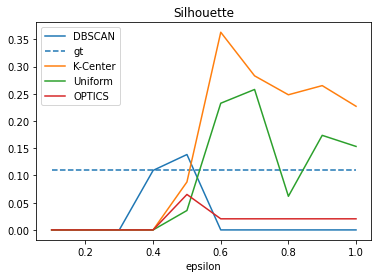

In [136]:
plt.title('Silhouette')
plt.plot(np.linspace(0.1, 1, 10), all_metrics['dbscan']['silhouette'], label='DBSCAN')
plt.hlines(y=silhouette_score(X, y), xmin=0.1, xmax=1, linestyle='dashed', label='gt')
plt.plot(np.linspace(0.1, 1, 10), all_metrics['k-center']['silhouette'], label='K-Center')
plt.plot(np.linspace(0.1, 1, 10), all_metrics['uniform']['silhouette'], label='Uniform')
plt.plot(np.linspace(0.1, 1, 10), all_metrics['optics']['silhouette'], label='OPTICS')
plt.legend()
plt.xlabel('epsilon')
plt.show()

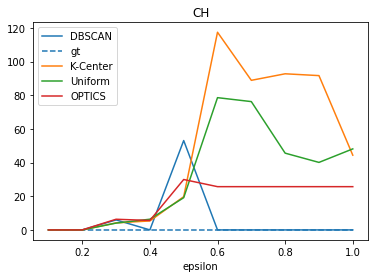

In [133]:
plt.title('CH')
plt.plot(np.linspace(0.1, 1, 10), all_metrics['dbscan']['ch'], label='DBSCAN')
plt.hlines(y=calinski_harabasz_score(X, y), xmin=0.1, xmax=1, linestyle='dashed', label='gt')
plt.plot(np.linspace(0.1, 1, 10), all_metrics['k-center']['ch'], label='K-Center')
plt.plot(np.linspace(0.1, 1, 10), all_metrics['uniform']['ch'], label='Uniform')
plt.plot(np.linspace(0.1, 1, 10), all_metrics['optics']['ch'], label='OPTICS')
plt.legend()
plt.xlabel('epsilon')
plt.show()

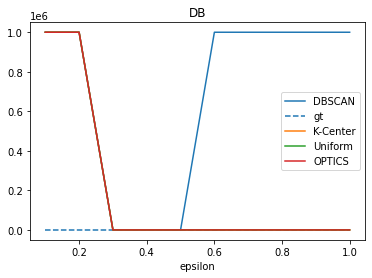

In [132]:
plt.title('DB')
plt.plot(np.linspace(0.1, 1, 10), all_metrics['dbscan']['db'], label='DBSCAN')
plt.hlines(y=davies_bouldin_score(X, y), xmin=0.1, xmax=1, linestyle='dashed', label='gt')
plt.plot(np.linspace(0.1, 1, 10), all_metrics['k-center']['db'], label='K-Center')
plt.plot(np.linspace(0.1, 1, 10), all_metrics['uniform']['db'], label='Uniform')
plt.plot(np.linspace(0.1, 1, 10), all_metrics['optics']['db'], label='OPTICS')
plt.legend()
plt.xlabel('epsilon')
plt.show()

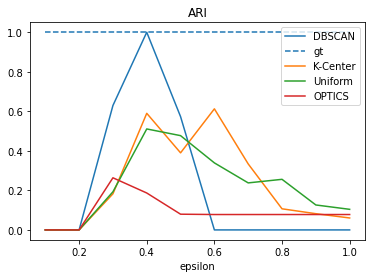

In [131]:
plt.title('ARI')
plt.plot(np.linspace(0.1, 1, 10), all_metrics['dbscan']['adj_rand'], label='DBSCAN')
plt.hlines(y=adjusted_rand_score(y, y), xmin=0.1, xmax=1, linestyle='dashed', label='gt')
plt.plot(np.linspace(0.1, 1, 10), all_metrics['k-center']['adj_rand'], label='K-Center')
plt.plot(np.linspace(0.1, 1, 10), all_metrics['uniform']['adj_rand'], label='Uniform')
plt.plot(np.linspace(0.1, 1, 10), all_metrics['optics']['adj_rand'], label='OPTICS')
plt.legend()
plt.xlabel('epsilon')
plt.show()

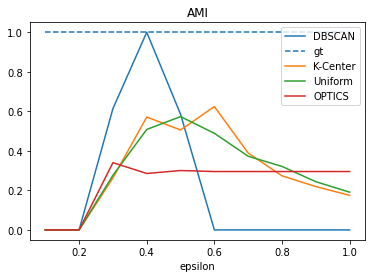

In [128]:
plt.title('AMI')
plt.plot(np.linspace(0.1, 1, 10), all_metrics['dbscan']['adj_mutual_info'], label='DBSCAN')
plt.hlines(y=adjusted_mutual_info_score(y, y), xmin=0.1, xmax=1, linestyle='dashed', label='gt')
plt.plot(np.linspace(0.1, 1, 10), all_metrics['k-center']['adj_mutual_info'], label='K-Center')
plt.plot(np.linspace(0.1, 1, 10), all_metrics['uniform']['adj_mutual_info'], label='Uniform')
plt.plot(np.linspace(0.1, 1, 10), all_metrics['optics']['adj_mutual_info'], label='OPTICS')
plt.xlabel('epsilon')
plt.legend()
plt.show()